In [1]:
import json
import gzip
import copy
import re
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import fisher_exact
from wordcloud import WordCloud

In [2]:
DO_ID_PATH_JSON = 'data/do/do_id.json'
DO_ID_PATH_OBO = 'data/do/doid.obo.txt'
PUBMED_PATH = 'data/do/human_pubmed.tab'
UNI2DO_PATH = 'data/do/uniprot_do.json'
DO_HUMAN = 'data/do/do_human.csv'

In [57]:
# Parse the disease ontology
do = {}  # { do_id : do_object }
obj = {}  # { id: do_id, name: definition, xref: list_of_omim_ids, is_a: list_of_parents, is_obsolete: True }
with open(DO_ID_PATH_OBO) as f:
    for line in f:
        line = line.strip().split(": ")
        
        if line and len(line) == 2:
            k, v = line
            if k == "id" and v.startswith("DOID:"):
                obj["id"] = v.split(":")[1]
            elif k == 'def':
                obj['descr'] = v.split('"')[1] 
            elif k == "xref" and "OMIM" in v:
                obj["omim"] = v.split(":")[1]
            elif k == "name":
                obj["name"] = v
            elif k == "is_a":
                obj.setdefault("is_a", []).append(v.split()[0].split(":")[1])
            elif k == "is_obsolete":
                obj["is_obsolete"] = True
        else:
            if obj.get("id") and not obj.get("is_obsolete"):
                do[obj["id"]] = obj
            obj = {}
            
name_do = {}
for k, v in do.items():
    name_do.setdefault(v['name'], k)

In [58]:
do_df = pd.DataFrame(do).transpose()
do_df.head()

,descr,id,is_a,name,omim
0001816,A vascular cancer that derives_from the cells ...,0001816,[175],angiosarcoma,NaN
0002116,A corneal disease that is characterized by a t...,0002116,[10124],pterygium,NaN
0014667,A disease that involving errors in metabolic p...,0014667,[4],disease of metabolism,NaN
0040001,A crustacean allergy that has_allergic_trigger...,0040001,[0060524],shrimp allergy,NaN
0040002,A drug allergy that has_allergic_trigger acety...,0040002,[0060500],aspirin allergy,NaN


In [5]:
pubmed = pd.read_table(PUBMED_PATH, sep = '\t', dtype=str) 
pubmed.head()

,Entry,Entry name,PubMed ID
0,Q96IY4,CBPB2_HUMAN,1939207; 14702039; 15057823; 15489334; 1057498...
1,P22362,CCL1_HUMAN,2809212; 2212659; 14702039; 15489334; 15340161...
2,Q8NCR9,CLRN3_HUMAN,17974005; 15164054; 15489334; 23033978
3,Q8IUK8,CBLN2_HUMAN,14702039; 12975309; 15489334
4,Q9BX69,CARD6_HUMAN,15489334; 22814378; 23186163


In [6]:
uniprot_pmid = {}
for n, i in enumerate(pubmed['PubMed ID'][pubmed['PubMed ID'].isna() == False].values):
    ids = i.strip().split('; ')
    for key in ids:
        uniprot_pmid.setdefault(key, []).append(pubmed.loc[n, 'Entry'])
        
pmids = list(uniprot_pmid.keys())
diseases = {}  # { uniprot_id : list_of_diseases }
URL = "https://www.ebi.ac.uk/europepmc/annotations_api/annotationsByArticleIds"
for i in tqdm(range(0, len(pmids), 8)):
    params = {"articleIds": ",".join(["MED:{}".format(pmid) for pmid in pmids[i:min(i + 8, len(pmids))]]), "type": "Diseases",
              "section"   : "Abstract", "format": "JSON"}
    r = requests.get(URL, params=params)
    obj = json.loads(r.text)
    for ele in obj:
        for annotation in ele.get("annotations"):
            for uniprot_id in uniprot_pmid[ele["extId"]]:
                if annotation["exact"] in name_do.keys():
                    DOID = name_do[annotation["exact"]]
                    diseases.setdefault(uniprot_id, set()).add(DOID)
diseases = {k: list(v) for k, v in diseases.items()}
diseases

  0%|          | 1/9592 [00:09<24:16:39,  9.11s/it]


KeyboardInterrupt: 

In [7]:
do_human_df = pd.merge(left=do_human, right=do_df, how='inner', left_on='do_id', right_on='id').iloc[:, [0, 1, 3, 4]]
do_human_df.sort_values(by=['entry_ac', 'do_id']).head()
do_human_df.to_csv('data/do/do_human.csv', sep='\t')

NameError: name 'do_human' is not defined

In [78]:
with open(UNI2DO_PATH) as file:
    do_human_dict = json.load(file)

do_human = []
for key in do_human_dict.keys():
    for ids in do_human_dict[key]:
        do_human.append([key, ids])
do_human = pd.DataFrame(do_human, columns=['entry_ac', 'do_id'])
do_human.sort_values(by=['entry_ac', 'do_id']).head()

,entry_ac,do_id
21824,A0A075B6H7,0050460
21822,A0A075B6H7,0060058
21825,A0A075B6H7,0080322
21821,A0A075B6H7,1240
21823,A0A075B6H7,12858


In [8]:
do_human = pd.read_table('data/do/do_human.csv', index_col=[0], dtype=str).sort_values(by=['entry_ac', 'do_id'])
do_original = pd.read_table('data/do/do_original.csv', index_col = [0], dtype=str)

### ENRICHMENT DO

In [59]:
# Parse the disease ontology
do = {}  # { do_id : do_object }
obj = {}  # { id: do_id, name: definition, xref: list_of_omim_ids, is_a: list_of_parents, is_obsolete: True }
with open(DO_ID_PATH_OBO) as f:
    for line in f:
        line = line.strip().split(": ")
        
        if line and len(line) == 2:
            k, v = line
            if k == "id" and v.startswith("DOID:"):
                obj["id"] = v.split(":")[1]
            elif k == 'def':
                obj['descr'] = v.split('"')[1] 
            elif k == "xref" and "OMIM" in v:
                obj["omim"] = v.split(":")[1]
            elif k == "name":
                obj["name"] = v
            elif k == "is_a":
                obj.setdefault("is_a", []).append(v.split()[0].split(":")[1])
            elif k == "is_obsolete":
                obj["is_obsolete"] = True
        else:
            if obj.get("id") and not obj.get("is_obsolete"):
                do[obj["id"]] = obj
            obj = {}

            
ontology = pd.DataFrame(do).transpose()
# Duplicate the index column assinging it the name 'do_id'
ontology.insert(loc=0, column='do_id', value=ontology.index)
# Set to None the roots' parent id
ontology.is_a[ontology.is_a.isna()] = None

# Format 'is_a' column converting it in a string of DO ids separated by a semicolumn
def f(x):
    if type(x) == list:
        return '; '.join(x)
    else:
        return x
    
ontology.is_a = ontology.is_a.map(f)

# Save the dataframe
ontology.to_csv('data/do/do_ontology.csv', sep='\t')

ontology.head()

,do_id,descr,id,is_a,name,omim
0001816,0001816,A vascular cancer that derives_from the cells ...,0001816,175,angiosarcoma,NaN
0002116,0002116,A corneal disease that is characterized by a t...,0002116,10124,pterygium,NaN
0014667,0014667,A disease that involving errors in metabolic p...,0014667,4,disease of metabolism,NaN
0040001,0040001,A crustacean allergy that has_allergic_trigger...,0040001,0060524,shrimp allergy,NaN
0040002,0040002,A drug allergy that has_allergic_trigger acety...,0040002,0060500,aspirin allergy,NaN


In [66]:
"""
To retrieve the GO that are parents, we cycle over ontology["graphs"][0]["edges"] which is a list of dictionary.
Every dictionary is about a GO id (sub) with a relation (pred) with another GO (obj).
We create a dictionary (parents) with as keys the sons and as values the parents. 
"""
def get_parents(ontology):
    # Mask used to filter roots
    not_a_root = (ontology.is_a.isna() == False)
    # Convert the 'is_a' field in a list of string and return a dict out of the dataframe
    return ontology.is_a[not_a_root].map(lambda x: x.split('; ')).to_dict()


"""
Here we cycle over the nodes to obtain a dictionary of GO_id with as value a description.  
- ontology["graphs"][0]["nodes"] is a list of dictionary with dict_keys(['id', 'meta', 'type', 'lbl'])
- ontology["graphs"][0]["nodes"][1]['lbl'] is the value (e.g: "endocytosed synaptic vesicle processing via endosome")
"""
def get_labels(ontology):
    return ontology['name'].to_dict()



"""
Build an ancestors dictionary with as key an GO_id and as value a list of GO_id which are the ancestors of the key.
Return ancestors = {GO_id : list of ancestor GO_ids}
"""
def get_ancestors(ontology):
    nodes = get_labels(ontology).keys()
    parents = get_parents(ontology)
    ancestors = {}
    for node in nodes:
        node_ancestors = []
        node_parents = parents.get(node)
        # Loop parent levels until no more parents
        while node_parents:
            node_ancestors.extend(node_parents)
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        ancestors[node] = node_ancestors
    return ancestors



"""
Build a dictionary for the children (similar to the ancestors one)
Return {node : list_of_children}, leaf terms are not keys.
"""
def get_children(ontology):
    ancestors = get_ancestors(ontology)
    children = {}  
    for node in ancestors:
        for ancestor in ancestors[node]:
            children.setdefault(ancestor, set()).add(node)
    return children



"""
Calculate the minimum depth (distance from the closest root) of each term
"""
def get_depth(ontology):
    # Identify nodes with no predecessors
    nodes, parents = ontology.do_id, get_parents(ontology)
    roots = set(nodes) - set(parents.keys())
    # Init the dictionary
    depth = {}
    for node in nodes:
        c = 0
        # Get parents of the node, return None if node is a root
        node_parents = parents.get(node)
        while node_parents:
            c += 1
            # Break the loop if the root is among parents
            if roots.intersection(set(node_parents)):
                break
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
        depth[node] = c
    return depth



"""
Perform Fisher test. An Odd-Ratio above 77 tells us the GO prefers the first dataframe (p-value < 0.05), 
while an Odd-Ratio under 0.013 tells us the GO prefers the second dataframe.
Return a Dataframe with index the GO and values the Odd-Ratio and the p-value.
"""
def fisher_test(df1, df2, col_name_go = 'go_id'):
    
    # Inint dict
    results = {}
    
    # Get the number of occurrances of the GO counts
    dict1, dict2 = dict(df1[col_name_go].value_counts()), dict(df2[col_name_go].value_counts())
    
    # Compute the intersaction of the GO terms
    key_intersection = set(dict1.keys()).intersection(set(dict2.keys()))
    
    for key in key_intersection:
        ### 1. Set frequencies
        # Number of occurrences of the specific GO term in DF1   
        tp = dict1[key]
        # Number of occurrences of the specific GO term in DF2
        tn = dict2[key]
        # Number of GO terms that are different from the specific one in DF1
        fp = sum(dict1.values()) - tp
        # Number of GO terms that are different from the specific one in DF2
        fn = sum(dict2.values()) - tn
        # 2. Perform Fisher Exact Test
        fisher_results = fisher_exact([[tp, tn],[fp, fn]])
        # 3. Save results
        results.setdefault(key, {'OddRatio': fisher_results[0], 'p-value': fisher_results[1]})
    
    # Return the DataFrame
    return pd.DataFrame(results).transpose()



"""
Function that assign to every GO terms the minimum p-value between its own p-value and the p-values of their children. 
"""
def transmit_pvalue(enrichment, ontology):
    # 1. Get the children of every GO term
    children_dict = get_children(ontology)
    # 2. For every GO in our enrichment dataset we assign to it the minimum p-value of its children 
    for go_id in enrichment.index:
        # Check if the GO term has child
        if children_dict.get(go_id):
            # Retrieve the set of the p-values of all its children
            pvalues = enrichment['p-value'][enrichment.index.isin(children_dict[go_id])]
            # Check we have some children in the dataset. Otherwise we have an empy set 'pvalues'
            if list(pvalues.values):
                # Check if the mimimum pvalue is actually lower than the ancestor one
                min_pvalue = pvalues.min()
                if min_pvalue < enrichment['p-value'][enrichment.index == go_id].values[0]:
                    # If all the conditions are True we assign the minimum pvalue
                    enrichment['p-value'][enrichment.index == go_id] = min_pvalue
    return enrichment
        
    

"""
Pipeline for the enrichment test. Take as input two dataframe and the onotlogy file.
Return a Dataframe with as index the GO_ids and values:
1. the p-value and Odd-Ration of the Fisher exact test,
2. the depth computed from the ontology file
3. the description of the GO_ids
"""
def enrich(df1, df2, ontology, col_name_go = 'go_id', col_name_descr='go_descr'):
    # 1. Get Fisher results
    df = fisher_test(df1, df2, col_name_go=col_name_go)
    # 2. Get Depth
    depth = get_depth(ontology)
    # 4. Update dataframe
    labels_, depth_ = [], []
    for go_id in df.index:
        labels_.append(ontology[col_name_descr][ontology[col_name_go] == go_id].values[0])
        depth_.append(depth[go_id])
    df['depth'] = depth_
    df[col_name_descr] = labels_
    # 5. Return dataframe 
    return df



"""
Filter the enrich dataframe by taking out GO_terms with high p-value or high depth
"""
def enrich_filter(df, max_pvalue=0.05, max_depth=5):
    df_filter = df[(df['p-value'] < max_pvalue) & (df['depth'] <= max_depth)]
    df_filter['score'] = np.log(1/df['p-value'])
    return df_filter



"""
Create the word cloud of the description of the enriched dataframe, using as frequencies the inverse of p-value  
"""
def word_cloud(df, col_name, col_score, *args, **kwargs):
    return WordCloud(*args, **kwargs).generate_from_frequencies({
           row[col_name]: row[col_score] for i, row in df.iterrows()})

In [67]:
ontology.head()

,do_id,descr,id,is_a,name,omim
1816,0001816,A vascular cancer that derives_from the cells ...,0001816,175,angiosarcoma,NaN
2116,0002116,A corneal disease that is characterized by a t...,0002116,10124,pterygium,NaN
14667,0014667,A disease that involving errors in metabolic p...,0014667,4,disease of metabolism,NaN
40001,0040001,A crustacean allergy that has_allergic_trigger...,0040001,0060524,shrimp allergy,NaN
40002,0040002,A drug allergy that has_allergic_trigger acety...,0040002,0060500,aspirin allergy,NaN


In [97]:
# 3. Load the required files
ontology = pd.read_csv('data/do/do_ontology.csv', sep='\t', dtype=str, index_col=[0])
#ontology.index = ontology.do_id.values
### DF1 and DF2
original_do = pd.read_table('data/do/do_original.csv', dtype=str, index_col=[0])
background_do = pd.read_table('data/do/do_human.csv', dtype=str, index_col=[0])

print(type(ontology.iloc[0, 3]))
print(len(ontology.iloc[0, 3]))
print(type(ontology.iloc[0, 3][0]))

<class 'str'>
3
<class 'str'>


In [134]:
"""
Calculate the minimum depth (distance from the closest root) of each term
"""
def get_depth(ontology):
    # Define the nodes list
    nodes = ontology.do_id.values
    # Define the dict that associates to each DO its parents
    parents = get_parents_int(ontology)
    # Identify nodes with no predecessors
    roots = set([int(n) for n in ontology.do_id.values]) - set(parents.keys())
    # Init the dictionary
    depth = {}
    for node in nodes:
        c = 0
        # Get parents of the node, return None if node is a root
        node_parents = parents.get(int(node))
        while node_parents:
            c += 1
            # Break the loop if the root is among parents
            if roots.intersection(set(node_parents)):
                break
            # Get the parents of current parents (1 level up)
            node_parents = [term for parent in node_parents for term in parents.get(parent, [])]
            #print(node_parents)
        depth[node] = c
    return depth



def get_parents_int(ontology):
    # Filter roots
    df = ontology[ontology.is_a.isna() == False]
    # Convert the 'is_a' field in a list of integers
    is_a_int = df.is_a.map(lambda x: [int(n) for n in x.split('; ')])
    # Return a dict having do_id as keys and is_a as values
    return dict(zip(df.index, is_a_int))



get_depth(ontology)

{'0001816': 5,
 '0002116': 7,
 '0014667': 1,
 '0040001': 9,
 '0040002': 6,
 '0040003': 7,
 '0040004': 7,
 '0040005': 7,
 '0040006': 6,
 '0040007': 6,
 '0040008': 6,
 '0040009': 6,
 '0040010': 6,
 '0040011': 6,
 '0040012': 6,
 '0040013': 6,
 '0040014': 6,
 '0040015': 6,
 '0040016': 6,
 '0040017': 6,
 '0040018': 6,
 '0040019': 6,
 '0040020': 7,
 '0040021': 6,
 '0040022': 6,
 '0040023': 7,
 '0040024': 7,
 '0040025': 7,
 '0040026': 6,
 '0040027': 6,
 '0040028': 6,
 '0040029': 6,
 '0040030': 7,
 '0040031': 6,
 '0040032': 6,
 '0040033': 7,
 '0040034': 6,
 '0040035': 6,
 '0040036': 6,
 '0040037': 7,
 '0040038': 8,
 '0040040': 8,
 '0040041': 7,
 '0040042': 8,
 '0040043': 8,
 '0040044': 8,
 '0040045': 6,
 '0040046': 6,
 '0040047': 7,
 '0040048': 7,
 '0040049': 7,
 '0040050': 7,
 '0040051': 7,
 '0040052': 6,
 '0040053': 6,
 '0040054': 6,
 '0040055': 6,
 '0040056': 6,
 '0040057': 6,
 '0040058': 6,
 '0040059': 6,
 '0040060': 6,
 '0040061': 6,
 '0040062': 6,
 '0040063': 6,
 '0040064': 6,
 '0040065'

In [136]:
df_enrich = enrich(df1=original_do, df2=background_do, ontology=ontology, col_name_go='do_id', col_name_descr='name')
df_enrich = transmit_pvalue(df_enrich, ontology)
df_enrich = enrich_filter(df_enrich, max_pvalue=0.05, max_depth=5)

/home/domenico/Documenti/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [138]:
df_enrich.sort_values(by='p-value').head(20)

,OddRatio,p-value,depth,name,score
0050886,153.127329,0.000160,5,Troyer syndrome,8.737673
11723,23.547539,0.003855,5,Duchenne muscular dystrophy,5.558432
0050454,60.871605,0.019607,3,periventricular nodular heterotopia,3.931877
0050477,60.871605,0.019607,5,Liddle syndrome,3.931877
14748,50.725309,0.022837,5,Sotos syndrome,3.779361
14731,50.725309,0.022837,2,Weaver syndrome,3.779361
8566,7.550035,0.030847,3,herpes simplex,3.478719
9970,3.291763,0.036950,5,obesity,3.298192
1240,1.714868,0.046051,4,leukemia,3.078000


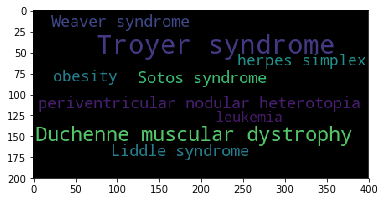

In [139]:
a = word_cloud(df_enrich, col_name='name', col_score='score')
plt.imshow(a)